<a href="https://colab.research.google.com/github/AntonioWanderer/CompPhys22/blob/main/Hopf_Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Уравнение Хопфа

Данное квазилинейное уравнение описывает движение газа невзаимодействующих частиц. Предлагается решить его численно двумя различными численными схемами. 

# Постановка задачи

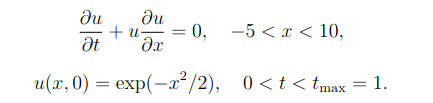

# Импорты

In [488]:
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
from math import *

# Графические функции

In [489]:
#Отрисовка поверхности решения U(x, t). Значение mkFrames запускает процесс
# сборки видео с обзором поверхности в течение полного оборота
# numFrames - количество кадров анимации
def graph3D(points, xFrom=-5, xTo=10, timeFrom=0, timeTo=1, xIntervals=20, timeIntervals=20, mkFrames=False, name="NoName", numFrames=60):
  fig = plt.figure()
  ax_3d = fig.add_subplot(projection='3d')

  ax_3d.set_xlabel("X, m")
  ax_3d.set_ylabel("T, s")
  ax_3d.set_zlabel("U, m/s")

  x = np.linspace(xFrom, xTo, xIntervals+1)
  t = np.linspace(timeFrom,timeTo,timeIntervals+1)
  X, Y = np.meshgrid(t, x)

  ax_3d.plot_wireframe(Y, X, points, color='black')
  plt.show()

  if mkFrames:
    print("Frames preparing...")
    if not os.path.exists(name+"_frames"): #создание папки под кадры если её нет
      os.makedirs(name+"_frames") 
    framesNames = []
    for ang in range(numFrames):
      ang = int(360/numFrames) * ang #угол обзора
      framesNames.append(str(ang)) #имена кадров для сборки анимации
      ax_3d.view_init(30, ang) #установка угла обзора
      fig.savefig(name+"_frames/" + str(ang)+".jpg", dpi = 300)
      fig.savefig(name+"_frames/" + str(ang)+".jpg", dpi = 300)
    mkVid(name+"_frames/", name, framesNames, 10) #сборка видео

In [490]:
#отрисовка U(x) с течением времени
def graph2D(points, xFrom=-5, xTo=10, timeFrom=0, timeTo=10, xIntervals=20, timeIntervals=20, mkFrames = False, name="NoName"):
  fig = plt.figure()
  ax = plt.axes()
  ax.set_xlabel("X, m")
  ax.set_ylabel("U, m/s")
  dx = (xTo - xFrom) / xIntervals
  dt = (timeTo - timeFrom) / timeIntervals
  for t in range(timeIntervals + 1):
    xP = [xFrom + x * dx for x in range(xIntervals+1)]
    zP = [points[x, t] for x in range(xIntervals+1)]
    clr = hex(255+int(256**2/(timeIntervals+1)*t)-1)[2:] #градиент цвета в течение расчётного времени
    while len(clr) < 6: #создание корректного формата цветового кода
      clr = "0" + clr
    ax.plot(xP, zP, color="#"+clr)
  plt.show()
  x0, x1 = ax.get_xlim() #получение итоговых размеров графика для фиксированой шкалы в анимации
  y0, y1 = ax.get_ylim()
  if mkFrames:
    print("Frames 2D preparing...")
    if not os.path.exists(name+"_frames"):
      os.makedirs(name+"_frames")
    framesNames = []
    for t in range(timeIntervals+1):
      framesNames.append(str(t))
      xP = [xFrom + x * dx for x in range(xIntervals+1)]
      zP = [points[x, t] for x in range(xIntervals+1)]
      ax.clear() #очистка графика для отрисовки в следующий момент времени
      ax.set_xlim(x0, x1) #установка фиксированных осей
      ax.set_ylim(y0, y1)
      ax.plot(xP, zP, color="g")
      fig.savefig(name+"_frames/" + str(t)+".jpg", dpi = 300)
      fig.savefig(name+"_frames/" + str(t)+".jpg", dpi = 300)
    mkVid(name+"_frames/", name, framesNames, timeTo-timeFrom)

In [491]:
#сборка видео по кадрам
def mkVid(path, name, framesNames, videoLength=10):
  print("Video rendering") 
  videoFps = int(len(framesNames)/videoLength)
  out = cv2.VideoWriter(name+".mp4",
                        cv2.VideoWriter_fourcc('m','p','4','v'),
                        videoFps,
                        (1800,1200))
  for i in framesNames:
    frame = cv2.imread(path + i + ".jpg")
    out.write(frame)
  out.release()
  cv2.destroyAllWindows()
  print("Done! Your video file is:\n"+name+".mp4")

# Начальные условия

In [492]:
def ZeroF(x): #функция в нулевой момент времени 
  y = exp(-(x-1)**2 / 2)
  # if x>0:
  #   return 0
  # else:
  #   return 1
  return y

In [493]:
#создание нулевого слоя U(x, 0)
def TimeBoundaryCondition(xFrom=-5, xTo=10, intervals=20):
  condition = np.zeros(intervals + 1)
  dx = (xTo - xFrom) / intervals
  for step in range(intervals + 1):
    x = xFrom + step * dx
    condition[step] = ZeroF(x)
  return condition

In [494]:
#Для неявных схем: 
#A1*U(xFrom) + B1*U'(xFrom) = C1
#A2*U(xTo) + B2*U'(xTo) = C2
A1 = 1
B1 = 0
C1 = 0
A2 = 1
B2 = 0
C2 = 0

# Реализация схем

In [495]:
#получение U(x, t + tau) по явной схеме
def Explicit(uL, uM, uR, h, tau):
  result = uM *(uR - uL) * tau / (2 * h) + uM
  return result

In [496]:
#решение трёхдиагональной матрицы методом прогонки
def Method3Diag(a, b, c, d, n):
    y = np.zeros(n+2)
    #forward
    for i in range(1, n+2):
        ksi = a[i]/b[i-1]
        a[i] = 0
        b[i] -= ksi * c[i-1]
        d[i] -= ksi * d[i-1]    
    #back
    y[n+1] = 2 * d[n+1] / b[n+1]
    
    for i in range(n, -1, -1):
        y[i] = 1/b[i] * (d[i] - c[i]*y[i+1])
    
    return y

In [497]:
# Получение нового временного слоя по схеме Кранка-Николсона
def SolvingHalf(n, h, tau, x):
  # подготовка коэффициентов для трёхдиагональной матрицы 
  a = - x /(4*h)
  b = np.ones(n+1) / tau 
  c = x / (4*h)
  d = np.array([0]+[x[i]*(1/tau+(x[i-1]-x[i+1])/(4*h)) for i in range(1, n)]+[0])
  # учёт граничных условий
  b[0] = A1 - B1 / h
  c[0] = B1 / h
  d[0] = C1
  b[-1] = A2 - B2 / h
  c[-1] = B2 / h
  d[-1] = C2

  y = Method3Diag(a, b, c, d, n-1)
  return y

In [498]:
#Получение нового временного слоя по неявной схеме
def SolvingImplicit(n, h, tau, x):
  # 3-diagonal matrix preparing 
  a = - x /(2*h)
  b = np.ones(n+1) / tau 
  c = x/(2*h)
  d = x/tau

  b[0] = A1 - B1 / h
  c[0] = B1 / h
  d[0] = C1
  b[-1] = A2 - B2 / h
  c[-1] = B2 / h
  d[-1] = C2

  y = Method3Diag(a, b, c, d, n-1)
  return y

In [499]:
# Нахождение U(x, t) на заданной сетке по явной схеме
def ComputeExplicit(xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals):
  solution = np.zeros((xIntervals + 1,timeIntervals + 1))
  solution[:,0] = TimeBoundaryCondition(xFrom, xTo, xIntervals)
  h = (xTo - xFrom) / xIntervals
  dt = (timeTo - timeFrom) / timeIntervals
  for t in range(timeIntervals):
    solution[0, t + 1] = solution[0, t]
    for x in range(1,xIntervals):
      solution[x, t + 1] = Explicit(solution[x+1, t], solution[x, t], solution[x - 1, t], h, dt)
    solution[-1, t + 1] = solution[-1, t]
  return solution

In [500]:
# Нахождение U(x, t) на заданной сетке по схеме Кранка-Николсона
def ComputeHalf(xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals):
  solution = np.zeros((xIntervals + 1,timeIntervals + 1))
  solution[:,0] = TimeBoundaryCondition(xFrom, xTo, xIntervals)
  h = (xTo - xFrom) / xIntervals
  dt = (timeTo - timeFrom) / timeIntervals
  for t in range(timeIntervals):
    solution[:,t+1] = SolvingHalf(xIntervals, (xTo-xFrom)/xIntervals, (timeTo-timeFrom)/timeIntervals, solution[:,t])
  return solution

In [501]:
# Нахождение U(x, t) на заданной сетке по неявной схеме
def ComputeImplicit(xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals):
  solution = np.zeros((xIntervals + 1,timeIntervals + 1))
  solution[:,0] = TimeBoundaryCondition(xFrom, xTo, xIntervals)
  h = (xTo - xFrom) / xIntervals
  dt = (timeTo - timeFrom) / timeIntervals
  for t in range(timeIntervals):
    solution[:,t+1] = SolvingImplicit(xIntervals, (xTo-xFrom)/xIntervals, (timeTo-timeFrom)/timeIntervals, solution[:,t])
  return solution

# Условия, при которых не происходит опрокидывание

In [502]:
#задание сетки
xIntervals = 200
timeIntervals = 50
xFrom = -5
xTo = 10
timeFrom = 0
timeTo = 1

# Анализ результатов

<ipython-input-495-97ac888a3564>:3: RuntimeWarning: overflow encountered in double_scalars
  result = uM *(uR - uL) * tau / (2 * h) + uM
<ipython-input-495-97ac888a3564>:3: RuntimeWarning: invalid value encountered in double_scalars
  result = uM *(uR - uL) * tau / (2 * h) + uM


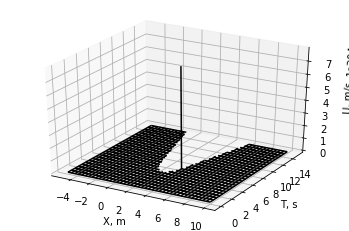

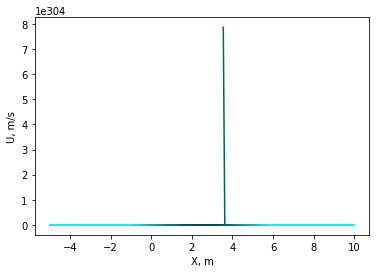

In [503]:
#По явной схеме
pointsE = ComputeExplicit(xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals)
graph3D(pointsE, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, False)
graph2D(pointsE, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals)

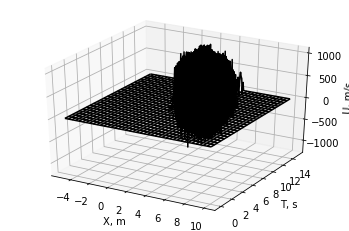

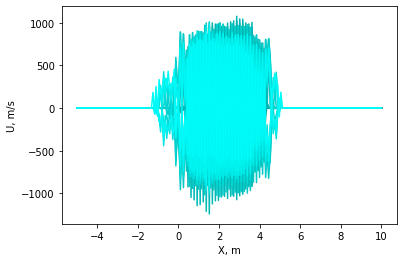

In [504]:
#По схеме Кранка-Николсона
pointsH = ComputeHalf(xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals)
graph3D(pointsH, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, False)
graph2D(pointsH, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals)

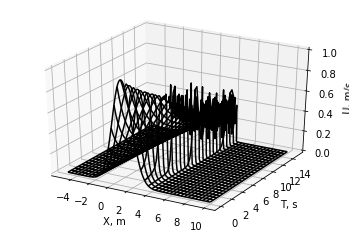

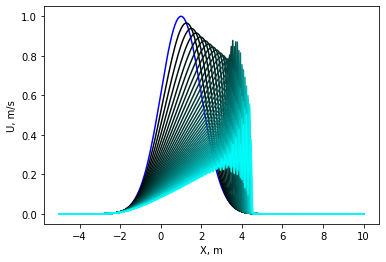

In [505]:
#По неявной
pointsI = ComputeImplicit(xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals)
graph3D(pointsI, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, False)
graph2D(pointsI, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals)

Как видно, за время t = 1 не возникает опрокидывания, а следовательно можно решать уравнение однозначно с точностью соответствующей численной схемы. При желании получить видео-анимации раскоментируйте нужные строки.

In [506]:
framesToShow3d = 50

In [507]:
nameString = "_"+str(timeFrom)+"-"+str(timeTo)+"s_"+str(xFrom)+"-"+str(xTo)+"m_"+str(xIntervals)+"x*"+ str(timeIntervals)+"t"
name3d = "3D" + nameString + str(framesToShow3d)
name2d = "2D" + nameString

In [508]:
# graph3D(pointsE, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, True, "Explicit"+name3d, framesToShow3d)
# graph3D(pointsH, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, True, "Half"+name3d, framesToShow3d)
# graph3D(pointsI, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, True, "Implicit"+name3d, framesToShow3d)

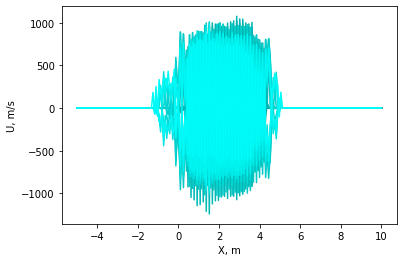

Frames 2D preparing...
Video rendering
Done! Your video file is:
Half2D_0-15s_-5-10m_200x*50t.mp4


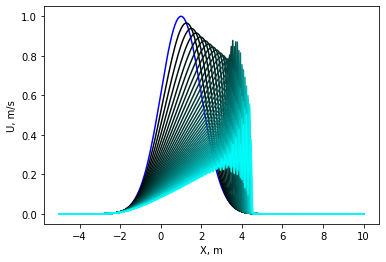

Frames 2D preparing...
Video rendering
Done! Your video file is:
Implicit2D_0-15s_-5-10m_200x*50t.mp4


In [509]:
# graph2D(pointsE, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, True,"Explicit"+name2d)
# graph2D(pointsH, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, True,"Half"+name2d)
# graph2D(pointsI, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, True,"Implicit"+name2d)

# Решение уравнения с заданной точностью

In [513]:
prec = 1e-3 #укажем наперёд заданную точность, которую хотим получить

xIntervals = 4
timeIntervals = 4
xFrom = -5
xTo = 10
timeFrom = 0
timeTo = 1

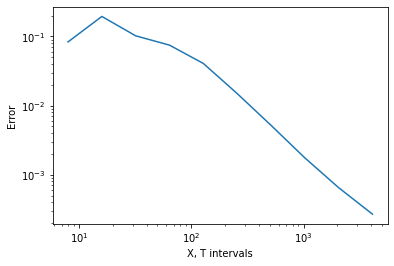

12 0.00026938667720732834


In [514]:
errors = []
intervals = []
iX = 1
iT = 1
while True:
  iX += 1
  iT += 1
  xIntervals = 2 ** iX
  timeIntervals = 2 ** iT
  dx = (xTo - xFrom)/xIntervals
  dt = (timeTo - timeFrom)/timeIntervals
  pointsE = ComputeExplicit(xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals)
  if iX > 2:
    m = 0
    for nT in range(timeIntervals//2+1):
      for nX in range(xIntervals//2+1):
        diff = abs(pointsE[nX*2, nT*2] - pointsEPast[nX, nT])
        if diff > m:
          m = diff
    intervals.append(timeIntervals)
    errors.append(m)
  if m < prec/2:
    break
  pointsEPast = pointsE
fig = plt.figure()
ax = plt.axes()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("X, T intervals")
ax.set_ylabel("Error")
ax.plot(intervals, errors)
plt.show()
print(iX, m)

# Список литературы
https://keldysh.ru/papers/2018/prep2018_17.pdf

http://new.math.msu.su/diffur/pde-first.pdf